In [131]:
#!pip install WordCloud
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import re, string
import collections
import random

from wordcloud   import WordCloud, STOPWORDS

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer,TfidfVectorizer
from sklearn.model_selection import train_test_split,GridSearchCV,StratifiedKFold

from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize, sent_tokenize


In [132]:
def random_colors(number_of_colors):
    '''Input = number of colors you want to generate
       Outpout = list of colors generated'''
    colors=[]
    for i in range(number_of_colors):
        colors.append('#'+''.join([random.choice('0123456789ABCDEF') for j in range(6)] ))
    return colors

In [133]:
data = pd.read_csv('Tweets.csv')
data.shape

(14640, 15)

In [134]:
data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [135]:
data.isna().sum()

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

([<matplotlib.patches.Wedge at 0x216461962c8>,
 [Text(-0.4270504754628449, 1.0137198288516203, 'Negativos'),
  Text(-0.11897122131710539, -1.0935473691149902, 'Neutrales'),
  Text(0.961585420671111, -0.5341848731972505, 'Positivos')],
 [Text(-0.23293662297973355, 0.5529380884645201, '62.7%'),
  Text(-0.06489339344569384, -0.5964803831536309, '21.2%'),
  Text(0.5245011385478787, -0.2913735671985002, '16.1%')])

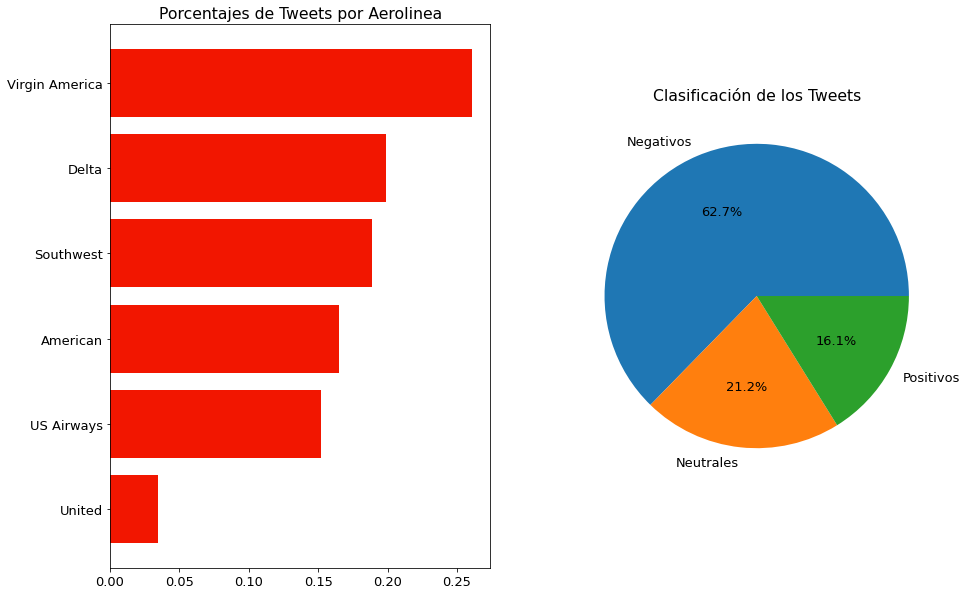

In [187]:
fig,ax = plt.subplots(1,2,figsize=(15,10))
ax = ax.ravel()
ax[0].set_title("Porcentajes de Tweets por Aerolinea")
ax[1].set_title("Clasificación de los Tweets")
ax[0].barh(data['airline'].value_counts(normalize = True).index,data['airline'].value_counts(normalize = True,ascending=True).values, color = random_colors(1))
ax[1].pie(data['airline_sentiment'].value_counts(normalize=True),shadow=False,labels=['Negativos','Neutrales','Positivos'],autopct='%1.1f%%')

In [137]:
data['tweet_long'] = data['text'].apply(lambda x : len(x))
data['tweet_long'].describe()

count    14640.000000
mean       103.822063
std         36.277339
min         12.000000
25%         77.000000
50%        114.000000
75%        136.000000
max        186.000000
Name: tweet_long, dtype: float64

Text(0.5, 0.98, 'Distribución de la Longitud de los Tweets')

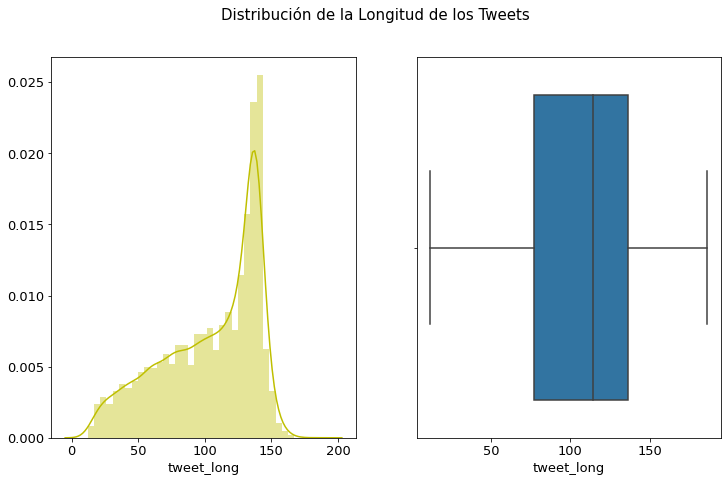

In [138]:
fig, ax = plt.subplots(1,2,figsize=(12,7))
sns.distplot(data['tweet_long'],ax=ax[0],color='y')
sns.boxplot(data['tweet_long'],orient='h',ax=ax[1])
fig.suptitle("Distribución de la Longitud de los Tweets", fontsize=15)

In [139]:

def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape('!"#$%&\()*+,-./:;<=>?@[\\]^_`{|}~'), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('thanks', 'thank', text)
    text = re.sub('amp', 'it is not my problem', text)
    for i in ['virginamerica','americanair','usairways','southwestair','jetblue','united','flight']: 
        text = text.replace(i,'')
    
    return text

data['text_clean'] = data['text'].apply(lambda x : clean_text(x))


In [140]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

data['text_clean'] = data['text_clean'].apply(lambda x : remove_emoji(x))


In [141]:
#List of stop words
stop_words=stopwords.words('english')
added_stop_words=["i'm",'u','ve','get']
for word in added_stop_words:
    stop_words.append(word)



In [142]:
#List of most common words with stop words ('lista')
tweet_list = [tweet for tweet in data['text_clean']]
lista=[]
for tweet in tweet_list:
    words = tweet.split()
    for word in words:
        lista.append(word)
#pd.DataFrame(collections.Counter(lista).most_common(10),columns=['Palabra','Frecuencia']).style.background_gradient(cmap='Blues')
df = pd.DataFrame(collections.Counter(lista).most_common(10),columns=['Palabra','Frecuencia'])

In [143]:
plt.rcParams.update({'font.size': 13})

Text(0.5, 1.0, 'Palabras más comunes en los tweets con stop words')

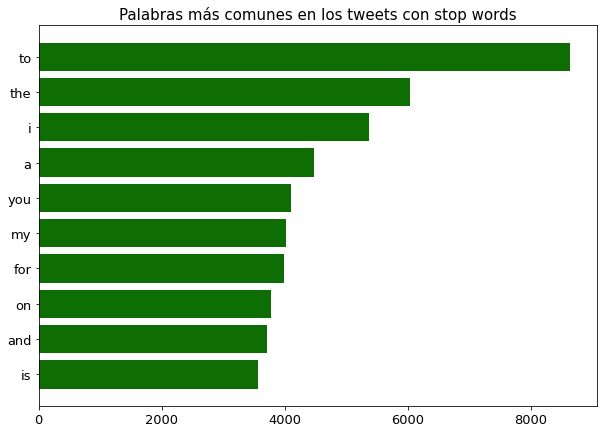

In [144]:
#Plot of most common words with stop words
fig,ax = plt.subplots(figsize=(10,7))
ax.barh(df['Palabra'],df['Frecuencia'],color=random_colors(1))
ax.invert_yaxis()
ax.set_title('Palabras más comunes en los tweets con stop words', fontsize='15')

In [145]:
#List of most common words without stop words ('lista_no_stopWords')
lista_no_stopWords = []
for tweet in tweet_list:
    words = tweet.split()
    for word in words:
        if word not in stop_words:
            lista_no_stopWords.append(word)
            
pd.DataFrame(collections.Counter(lista_no_stopWords).most_common(10),columns=['Palabra','Frecuencia']).style.background_gradient(cmap='Blues')

,Palabra,Frecuencia
0,thank,1672
1,cancelled,1057
2,service,951
3,help,854
4,time,768
5,problem,760
6,customer,744
7,us,678
8,hours,666
9,hold,637


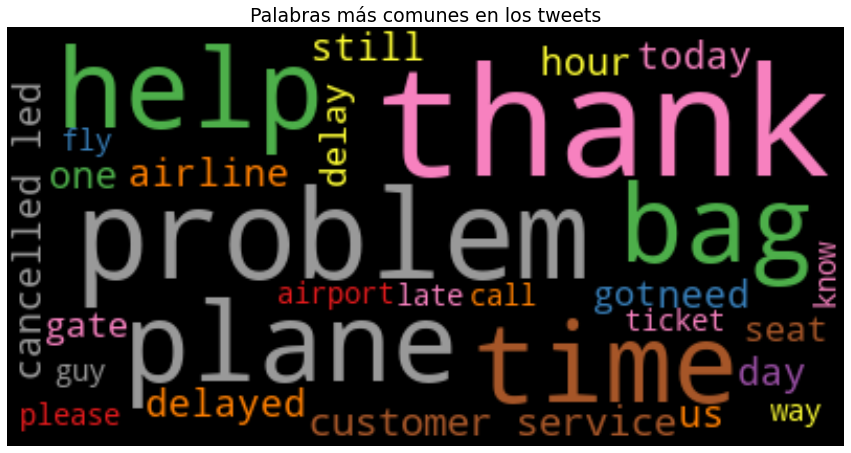

In [146]:
#Visualization of most common without stop words
text = ",".join(word for word in lista_no_stopWords)
wordcloud = WordCloud(max_words=30, colormap='Set1',background_color="black").generate(text)
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.figure(1,figsize=(12, 12))
plt.title('Palabras más comunes en los tweets',fontsize=19)
plt.show()

In [147]:
#Visualización de las palabras más comunes según clasificación de Tweet en positivo
mask_positive = data['airline_sentiment'] == 'positive'
data['text_clean'].loc[mask_positive]
positive_tweet_list = [tweet for tweet in data['text_clean'].loc[mask_positive]]
list_positive=[]
for tweet in positive_tweet_list:
    words = tweet.split()
    for word in words:
        if word not in stop_words:
            list_positive.append(word)
            
pd.DataFrame(collections.Counter(list_positive).most_common(10),columns=['Palabra','Frecuencia']).style.background_gradient(cmap='Blues')

,Palabra,Frecuencia
0,thank,1062
1,great,233
2,service,159
3,love,137
4,customer,112
5,good,110
6,guys,110
7,much,109
8,best,105
9,awesome,99


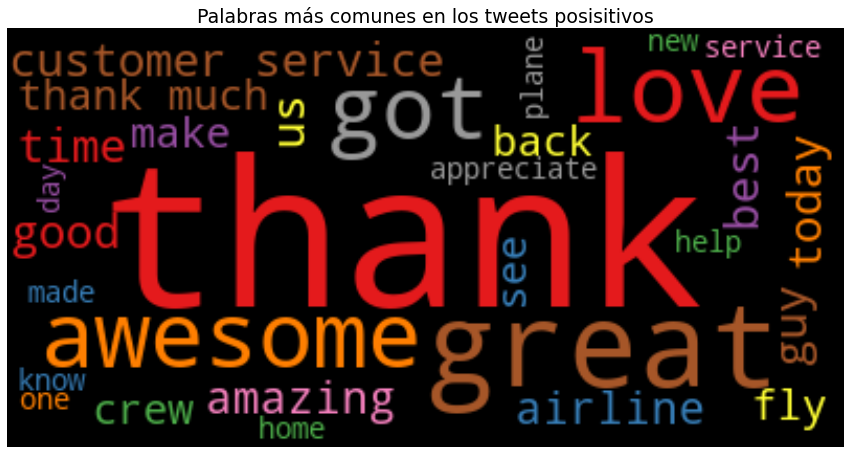

In [148]:
#Visualizacion de las principales palabras en los tweets positivos sin stop words
text = ",".join(word for word in list_positive if word!='problem')
wordcloud = WordCloud(max_words=30, colormap='Set1',background_color="black").generate(text)
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.figure(1,figsize=(12, 12))
plt.title('Palabras más comunes en los tweets posisitivos',fontsize=19)
plt.show()

In [149]:
#Visualización de las palabras más comunes según clasificación de Tweet en neutro
mask_neutral = data['airline_sentiment'] == 'neutral'
data['text_clean'].loc[mask_neutral]
neutral_tweet_list = [tweet for tweet in data['text_clean'].loc[mask_neutral]]
list_neutral=[]
for tweet in neutral_tweet_list:
    words = tweet.split()
    for word in words:
        if word not in stop_words:
            list_neutral.append(word)
            
pd.DataFrame(collections.Counter(list_neutral).most_common(10),columns=['Palabra','Frecuencia']).style.background_gradient(cmap='Blues')

,Palabra,Frecuencia
0,thank,223
1,please,179
2,need,162
3,help,162
4,would,122
5,dm,121
6,us,108
7,fleek,107
8,know,104
9,tomorrow,104


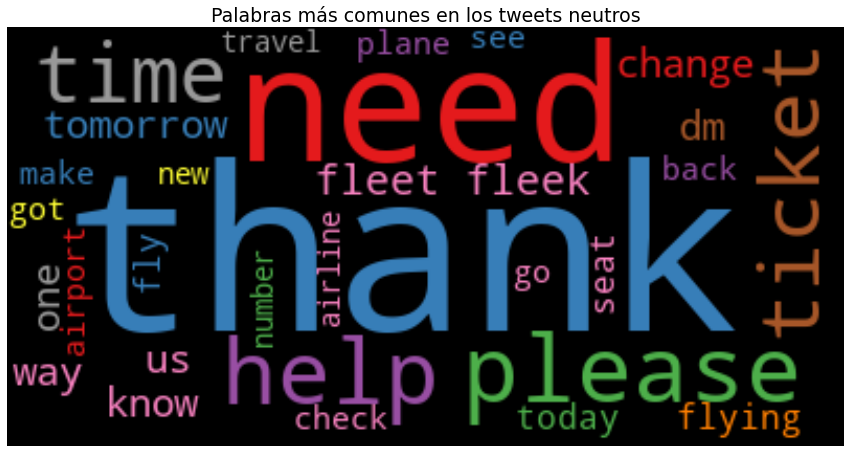

In [150]:
#Visualizacion de las principales palabras en los tweets neutros sin stop words
text = ",".join(word for word in list_neutral if word!='problem')
wordcloud = WordCloud(max_words=30, colormap='Set1',background_color="black").generate(text)
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.figure(1,figsize=(12, 12))
plt.title('Palabras más comunes en los tweets neutros',fontsize=19)
plt.show()

In [151]:
#Visualización de las palabras más comunes según clasificación de Tweet negativo
mask_negative = data['airline_sentiment'] == 'negative'
data['text_clean'].loc[mask_negative]
negative_tweet_list = [tweet for tweet in data['text_clean'].loc[mask_negative]]
list_negative=[]
for tweet in negative_tweet_list:
    words = tweet.split()
    for word in words:
        if word not in stop_words:
            list_negative.append(word)
            
pd.DataFrame(collections.Counter(list_negative).most_common(10),columns=['Palabra','Frecuencia']).style.background_gradient(cmap='Blues')

,Palabra,Frecuencia
0,cancelled,920
1,service,738
2,hours,641
3,help,610
4,hold,607
5,customer,604
6,time,582
7,problem,569
8,plane,515
9,delayed,493


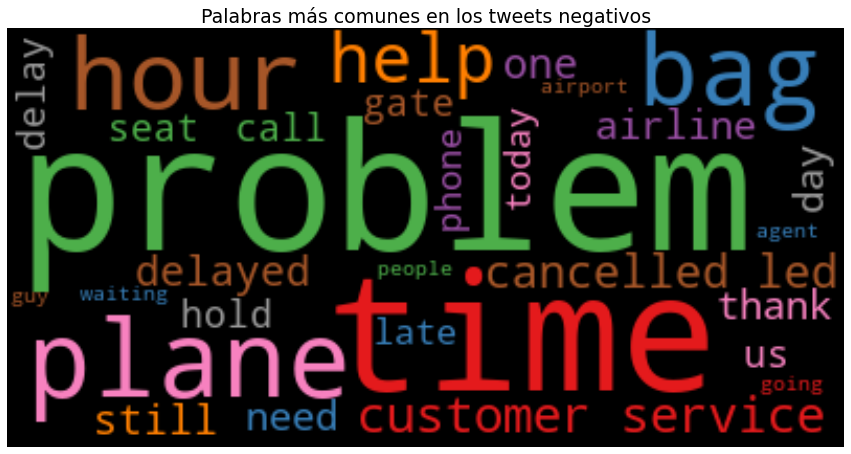

In [152]:
#Visualizacion de las principales palabras en los tweets negativos sin stop words
text2 = ",".join(word for word in list_negative)
wordcloud = WordCloud(max_words=30, colormap='Set1',background_color="black").generate(text2)
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.figure(1,figsize=(12, 12))
plt.title('Palabras más comunes en los tweets negativos',fontsize=19)
plt.show()

In [153]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
x = data['text_clean']
y = data['airline_sentiment']

train,test,y_train,y_test = train_test_split( x, y, stratify = y, random_state=49)

In [153]:
#Vectorización del set de entrenamiento utilizando CountVectorizer

vectorizer=CountVectorizer(stop_words=stop_words,strip_accents='unicode')

x_train = vectorizer.fit_transform(train)
x_test = vectorizer.transform(test)

In [154]:
#Model with LogisticRegression (CountVectorizer)

skf = StratifiedKFold(n_splits=3,random_state=49,shuffle=True) 
estimador = LogisticRegression(max_iter=250)
param_grid = {'C': np.arange(0.3,0.4,0.01)} 
grid = GridSearchCV(estimador,param_grid,cv=skf,n_jobs=-1)
grid.fit(x_train,y_train)
y_pred = grid.predict(x_test)

print('                    LogisticRegression\n')
print("Best cross-validation score:",np.round(grid.best_score_,3));
print("Best parameters: C =", np.round(grid.best_params_['C'],3),'\n')
print('Classification report:\n')
print(classification_report(y_test,y_pred))

                    LogisticRegression

Best cross-validation score: 0.771
Best parameters: C = 0.36 

Classification report:

              precision    recall  f1-score   support

    negative       0.83      0.91      0.87      2294
     neutral       0.66      0.55      0.60       775
    positive       0.77      0.63      0.69       591

    accuracy                           0.79      3660
   macro avg       0.75      0.70      0.72      3660
weighted avg       0.78      0.79      0.78      3660



[Text(0, 0.5, 'Negative'), Text(0, 1.5, 'Neutral'), Text(0, 2.5, 'Positive')]

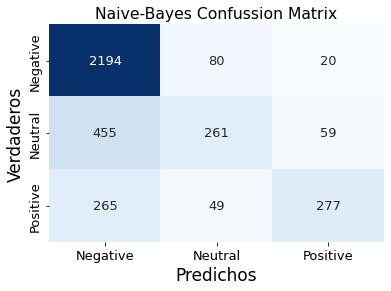

In [184]:
#Visualización de la matriz de confusión para LogisticRegression (CountVectorizer)
fig,ax = plt.subplots()
conf_matrix = confusion_matrix(y_test,y_pred)
ax = sns.heatmap(conf_matrix,annot=True,cbar= False,fmt='d',cmap='Blues')
ax.set_xlabel("Predichos",fontsize='17')
ax.set_ylabel("Verdaderos",fontsize='17')
ax.set_title('Naive-Bayes Confussion Matrix')
ax.set_xticklabels(['Negative','Neutral','Positive'])
ax.set_yticklabels(['Negative','Neutral','Positive'],fontdict={'verticalalignment': 'center'})

In [158]:
#Model with MultinomialNB (CountVectorizer)

skf = StratifiedKFold(n_splits=3,random_state=49,shuffle=True) 
estimador = MultinomialNB()
param_grid = {'alpha': np.arange(0.1,1,0.01)} 
grid = GridSearchCV(estimador,param_grid,cv=skf,n_jobs=-1)
grid.fit(x_train,y_train)
print('                    MultinomialNB\n')
print("Best cross-validation score:",np.round(grid.best_score_,3));
print("Best parameters: alpha =", np.round(grid.best_params_['alpha'],3),'\n');
y_pred = grid.predict(x_test)
print('Classification report:\n')
print(classification_report(y_test,y_pred))

                    MultinomialNB

Best cross-validation score: 0.75
Best parameters: alpha = 0.41 

Classification report:

              precision    recall  f1-score   support

    negative       0.79      0.92      0.85      2294
     neutral       0.67      0.42      0.52       775
    positive       0.73      0.62      0.67       591

    accuracy                           0.77      3660
   macro avg       0.73      0.66      0.68      3660
weighted avg       0.76      0.77      0.75      3660



In [159]:
confusion_matrix(y_test,y_pred)

array([[2120,  110,   64],
       [ 377,  329,   69],
       [ 171,   55,  365]], dtype=int64)

In [160]:
#Vectorización del set de entrenamiento utilizando TfidVectorizer
vectorizer=TfidfVectorizer(stop_words=stop_words,strip_accents='unicode');

X_tfidf_train=vectorizer.fit_transform(train);
X_tfidf_test=vectorizer.transform(test)


In [161]:
#Model with LogisticRegression (TfidfVectorizer)

skf = StratifiedKFold(n_splits=3,random_state=49,shuffle=True) 
estimador = LogisticRegression(max_iter=250)
param_grid = {'C': np.arange(0.6,0.7,0.01)} 
grid = GridSearchCV(estimador,param_grid,cv=skf,n_jobs=-1)
grid.fit(X_tfidf_train,y_train)
print('                    LogisticRegression\n')
print("Best cross-validation score:",np.round(grid.best_score_,3));
print("Best parameters: C =", np.round(grid.best_params_['C'],3),'\n');
y_pred = grid.predict(X_tfidf_test)
print('Classification report:\n')
print(classification_report(y_test,y_pred))

                    LogisticRegression

Best cross-validation score: 0.745
Best parameters: C = 0.68 

Classification report:

              precision    recall  f1-score   support

    negative       0.78      0.95      0.86      2294
     neutral       0.71      0.40      0.51       775
    positive       0.80      0.56      0.66       591

    accuracy                           0.77      3660
   macro avg       0.76      0.64      0.67      3660
weighted avg       0.77      0.77      0.75      3660



In [162]:
confusion_matrix(y_test,y_pred)

array([[2187,   63,   44],
       [ 432,  307,   36],
       [ 196,   65,  330]], dtype=int64)

In [163]:
#Model with MultinomialNB (TfidfVectorizer)

skf = StratifiedKFold(n_splits=3,random_state=49,shuffle=True) 
estimador = MultinomialNB()
param_grid = {'alpha': np.arange(0.01,1,0.01)} 
grid = GridSearchCV(estimador,param_grid,cv=skf,n_jobs=-1)
grid.fit(X_tfidf_train,y_train)
print('                    MultinomialNB\n')
print("Best cross-validation score:",np.round(grid.best_score_,3));
print("Best parameters: alpha =", np.round(grid.best_params_['alpha'],3),'\n');
y_pred = grid.predict(X_tfidf_test)
print('Classification report:\n')
print(classification_report(y_test,y_pred))

                    MultinomialNB

Best cross-validation score: 0.738
Best parameters: alpha = 0.07 

Classification report:

              precision    recall  f1-score   support

    negative       0.75      0.96      0.84      2294
     neutral       0.67      0.34      0.45       775
    positive       0.78      0.47      0.59       591

    accuracy                           0.75      3660
   macro avg       0.73      0.59      0.63      3660
weighted avg       0.74      0.75      0.72      3660



In [164]:
confusion_matrix(y_test,y_pred)

array([[2194,   80,   20],
       [ 455,  261,   59],
       [ 265,   49,  277]], dtype=int64)

In [165]:
#Preparación de los datos para reducción de dimensionalidad

from sklearn.feature_extraction.text import TfidfTransformer
vectorizer=CountVectorizer(stop_words=stop_words,strip_accents='unicode')
asd = vectorizer.fit_transform(data["text_clean"])
#Tfidf_encoding=TfidfTransformer().fit_transform(data["text_clean"]);
#pd.DataFrame(Tfidf_encoding.todense(),columns=vectorizer.get_feature_names())
Tfidf_encoding=TfidfTransformer().fit_transform(asd)

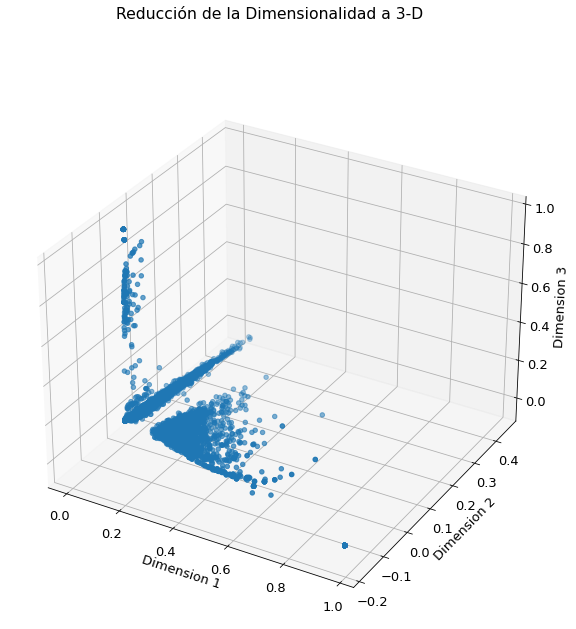

In [166]:
#Reducción de la dimensionalidad utilizando SVD
from sklearn.decomposition import TruncatedSVD

svd=TruncatedSVD(n_components=3);
P=svd.fit_transform(Tfidf_encoding)

x = [P[i][0] for i in range(len(P))]
y = [P[i][1] for i in range(len(P))]
z = [P[i][2] for i in range(len(P))]

#Representación gráfica de las 3 componentes
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_zlabel('Dimension 3')
fig.suptitle('Reducción de la Dimensionalidad a 3-D')
ax.scatter(x, y, z)

In [167]:
#Palabras con más peso en las componentes principales

comp1 , comp2 , comp3 = svd.components_ # coeficientes (pesos) de los términos en cada una de las 3 dimensiones

indices=np.argsort(comp1); # los ordenamos de menor a mayor y nos quedamos con los índices de sus posiciones en el array
indices=indices[::-1] # invertimos para que queden ordenados de mayor a menor

print('Dimension 1:')
print(np.array(vectorizer.get_feature_names())[indices][:20]) # Evaluamos los términos en estas posiciones

print('\n')

indices=np.argsort(comp2);
indices=indices[::-1]
print('Dimension 2:')
print(np.array(vectorizer.get_feature_names())[indices][:20])
print('\n')
indices=np.argsort(comp3);
indices=indices[::-1]
print('Dimension 3:')
print(np.array(vectorizer.get_feature_names())[indices][:20])




Dimension 1:
['thank' 'much' 'great' 'help' 'service' 'got' 'customer' 'cancelled' 'dm'
 'time' 'guys' 'response' 'sent' 'awesome' 'hold' 'hours' 'good' 'please'
 'ok' 'today']


Dimension 2:
['cancelled' 'hold' 'help' 'led' 'service' 'hours' 'customer' 'please'
 'call' 'time' 'need' 'hour' 'still' 'problem' 'us' 'phone' 'one' 'plane'
 'delayed' 'back']


Dimension 3:
['fleek' 'fleet' 'rt' 'stop' 'please' 'lol' 'smh' 'lmao' 'yall' 'dm' 'wow'
 'see' 'happened' 'hate' 'oh' 'okay' 'really' 'xx' 'late' 'madness']
